# Calculate Angles

Calculate dip angles on all ALHIC1901 datasets

## Setup

In [86]:
# Load packages

import os
os.environ['MKL_SERVICE_FORCE_INTEL'] = '1'

# general
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# math
from scipy.stats import pearsonr
import math

# my functions/classes
import sys
sys.path.append("../core_scripts/")
from ECMclass import ECM


In [94]:
# Set filepaths

path_to_data = '../../data/ecm/'
path_to_angles = '../../data/angles/'
path_to_figures = '../../../figures/angles/'

In [88]:
# Set parameters

# smoothing window
window = 1

# spacing of line that we interpolate onto
interp_int = 0.0001

# set angles to cycle through
ang = 55
ang_res = 5 #fraction of angle
test_angle = np.linspace(-ang,ang,2*ang*ang_res+1)

## Load Data

In [89]:
# Load metadata
meta = pd.read_csv(path_to_data + 'metadata.csv')
meta.head()

# for now, trim to just the first three rows
#meta = meta.iloc[5:8]

,core,time,section,face,ACorDC,Y_left,Y_right,AC_edgespace,DC_edgespace
0,alhic1901,cmc1,230_4,t,DC,-5.080,206.763,15,10
1,alhic1901,cmc1,230_4,l,DC,70.404,170.096,15,10
2,alhic1901,cmc1,228_4,t,DC,-10.000,192.000,15,10
3,alhic1901,cmc1,228_4,l,AC,63.881,166.250,15,10
4,alhic1901,cmc1,228_4,l,DC,65.891,149.177,15,10


In [90]:
# Load ECM data

data = []
cores = []
sections = []
faces = []
ACorDCs = []
for index, row in tqdm(meta.iterrows(), total=len(meta), desc="Processing data"):
    
    core = row['core']
        
    section = row['section']
    face = row['face']
    ACorDC = row['ACorDC']

    data_item = ECM(core,section,face,ACorDC)
    print("Reading "+core+", section "+section+'-'+face+'-'+ACorDC)
    
    data_item.rem_ends(15)
    data_item.smooth(window)
    data.append(data_item)
    data_item.norm_all()
    
    cores.append(core)
    sections.append(section)
    faces.append(face)
    ACorDCs.append(ACorDC)




Processing data:   8%|▊         | 1/13 [00:00<00:02,  5.79it/s]

Reading alhic1901, section 230_4-t-DC
Reading alhic1901, section 230_4-l-DC


Processing data:  23%|██▎       | 3/13 [00:00<00:01,  8.18it/s]

Reading alhic1901, section 228_4-t-DC
Reading alhic1901, section 228_4-l-AC


Processing data:  31%|███       | 4/13 [00:00<00:01,  7.80it/s]

Reading alhic1901, section 228_4-l-DC
Reading alhic1901, section 230_4-l-AC


Processing data:  46%|████▌     | 6/13 [00:00<00:00,  8.32it/s]

Reading alhic1901, section 230_4-t-AC


Processing data:  69%|██████▉   | 9/13 [00:01<00:00,  5.34it/s]

Reading alhic1901, section 230_4-r-DC
Reading alhic1901, section 230_4-r-AC


Processing data:  85%|████████▍ | 11/13 [00:01<00:00,  6.49it/s]

Reading alhic1901, section 228_4-r-DC
Reading alhic1901, section 228_4-r-AC
Reading alhic1901, section 228_4-o-AC


Processing data:  92%|█████████▏| 12/13 [00:02<00:00,  5.45it/s]

Reading alhic1901, section 228_4-t-AC


Processing data: 100%|██████████| 13/13 [00:02<00:00,  5.46it/s]


## Preform Angle Calculations

In [91]:
angles = []
scores = []
lengths = []
all_scores = []

# loop through each data file
for data_face in data:

    # print summary
    print("Calculating Angle: "+data_face.core+ 
          ", section "+data_face.section+ '-'+data_face.face+
          '-'+data_face.ACorDC)
    
    

    # make empty depth/angle
    score_list = []
    angle=[]
    angle_depth=[]

    # assign local variables
    depth = data_face.depth_s
    meas = data_face.meas_s
    y_list = data_face.y_s
    y_vec = data_face.y_vec

    # make empty array to score all scores
    all_score = np.zeros((len(test_angle),len(y_vec)-1))

    # flip the depth, meas, and y_list vectors
    depth = np.flip(depth)
    meas = np.flip(meas)
    y_list = np.flip(y_list)

    # make empty list of angle and scores
    angle_list = []
    score_list = []
    length_list = []

    # loop through each pair of adjasent tracks
    for i in range(len(y_vec)-1):

        # get two y_values
        y1 = y_vec[i]
        y2 = y_vec[i+1]
        y_space = abs(y2 - y1)

        # pull out data for both tracks
        idx1 = y_list == y1
        idx2 = y_list == y2
        meas1 = meas[idx1]
        meas2 = meas[idx2]
        depth1 = depth[idx1]
        depth2 = depth[idx2]

        run_score = []

        # loop through each angle
        a_cnt = 0
        for a in test_angle:
            
            # caluclate the spacing between tracks
            yspace = y1-y2

            # calculate the change in depth at this slope
            delta_depth = yspace/1000 * np.tan(a * np.pi/180) * 0.5

            # calculate the new depth vectors
            depth1_shifted = depth1 - delta_depth
            depth2_shifted = depth2 + delta_depth

            # Find the overlapping range between the two depth vectors
            min_overlap = max(min(depth1_shifted), min(depth2_shifted))
            max_overlap = min(max(depth1_shifted), max(depth2_shifted))

            # Round to the nearest 1mm (0.001), rounding min up and max down
            min_overlap_rounded = math.ceil(min_overlap * 1000) / 1000
            max_overlap_rounded = math.floor(max_overlap * 1000) / 1000

            # create new depth vector to interpolate onto
            depth_vec = np.arange(min_overlap_rounded, max_overlap_rounded, interp_int)
            length = max(depth_vec) - min(depth_vec)

            # interpolate the two tracks onto the new depth vector
            meas1_interp = np.interp(depth_vec, depth1_shifted, meas1)
            meas2_interp = np.interp(depth_vec, depth2_shifted, meas2)

            # calculate the correlation
            corr, pval = pearsonr(meas1_interp, meas2_interp)

            # caluclate the score
            run_score.append(corr*length)

            # save score in 2D array
            all_score[a_cnt,i] = corr
            a_cnt += 1

        # find the best score and angle
        best_score = max(run_score)
        best_angle = test_angle[run_score.index(best_score)]

        # append to the lists
        angle_list.append(best_angle)
        score_list.append(best_score)
        

    # Print rough stats
    print("    Mean Angle = "+str(np.mean(angle_list)))
    print("    Mean Angles = "+str(angle_list))
        
    # save the angles, corrs, and lengths
    angles.append(angle_list)
    scores.append(score_list)
    lengths.append(length_list)      
    all_scores.append(all_score)     

Calculating Angle: alhic1901, section 230_4-t-DC
    Mean Angle = 5.650000000000001
    Mean Angles = [37.0, -4.399999999999999, -0.19999999999999574, -0.5999999999999943, -0.5999999999999943, 20.799999999999997, 0.8000000000000043, -22.799999999999997, 53.400000000000006, -8.0, 20.799999999999997, -10.199999999999996, -0.7999999999999972, -0.7999999999999972, 5.0, 10.200000000000003, -0.7999999999999972, 14.600000000000009, 0.6000000000000014, -1.0]
Calculating Angle: alhic1901, section 230_4-l-DC
    Mean Angle = 20.175000000000004
    Mean Angles = [55.0, -19.0, -2.0, 38.60000000000001, 29.0, 27.0, 23.80000000000001, 9.0]
Calculating Angle: alhic1901, section 228_4-t-DC
    Mean Angle = -7.221052631578942
    Mean Angles = [4.400000000000006, -4.399999999999999, -14.599999999999994, -3.5999999999999943, -2.1999999999999957, 1.4000000000000057, -0.7999999999999972, -15.199999999999996, -31.599999999999998, -12.799999999999997, -21.199999999999996, -14.199999999999996, -2.599999999999

In [92]:
# Save the results

# Set up a df to store the results
face_df = meta.drop(columns=['Y_left', 'Y_right','AC_edgespace','DC_edgespace']).copy()

# save values
face_df['angle'] = angles
face_df['score'] = scores
face_df['length'] = lengths
face_df['all_scores'] = all_scores

# save the dataframe
face_df.head()

,core,time,section,face,ACorDC,angle,score,length,all_scores
0,alhic1901,cmc1,230_4,t,DC,"[37.0, -4.399999999999999, -0.1999999999999957...","[0.0744255528371454, 0.06784602099695096, 0.07...",[],"[[0.07711514905734641, -0.04004410152153174, -..."
1,alhic1901,cmc1,230_4,l,DC,"[55.0, -19.0, -2.0, 38.60000000000001, 29.0, 2...","[0.10215207000362973, 0.09886650471160678, 0.1...",[],"[[-0.12936020123921624, 0.5960439633189245, 0...."
2,alhic1901,cmc1,228_4,t,DC,"[4.400000000000006, -4.399999999999999, -14.59...","[0.126446898004823, 0.1312870232473385, 0.1293...",[],"[[0.7632054390728512, 0.7527185607123529, 0.83..."
3,alhic1901,cmc1,228_4,l,AC,"[5.800000000000004, 5.800000000000004, 5.0, 10...","[0.18972239489994255, 0.20872705462262367, 0.2...",[],"[[0.5763389003546153, 0.7149567736661093, 0.69..."
4,alhic1901,cmc1,228_4,l,DC,"[5.0, -0.3999999999999986, 2.6000000000000014,...","[0.1733425787617329, 0.1752404662106158, 0.170...",[],"[[0.4491052645506376, 0.5721835996477604, 0.46..."


## Diagnostic Plot

Shows the correlation strength as a function of angle for each track. Saves plot, and picks out a couple to show here.

<Figure size 640x480 with 0 Axes>

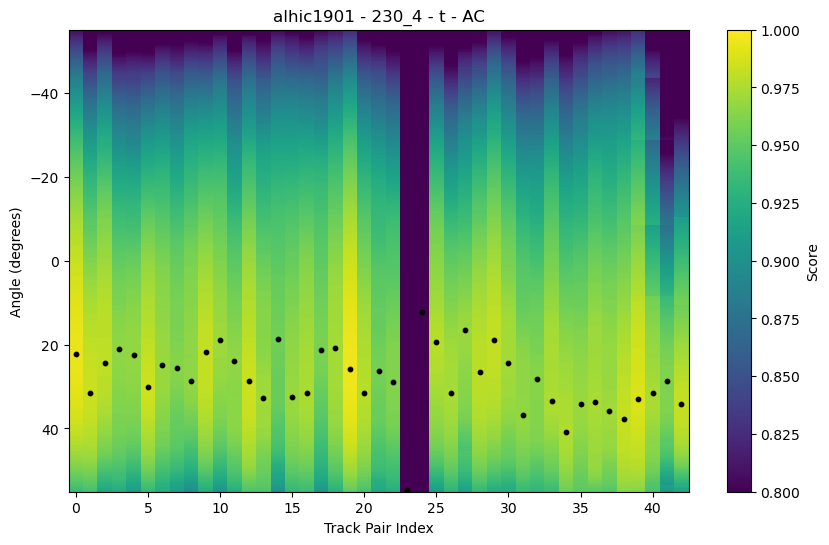

<Figure size 640x480 with 0 Axes>

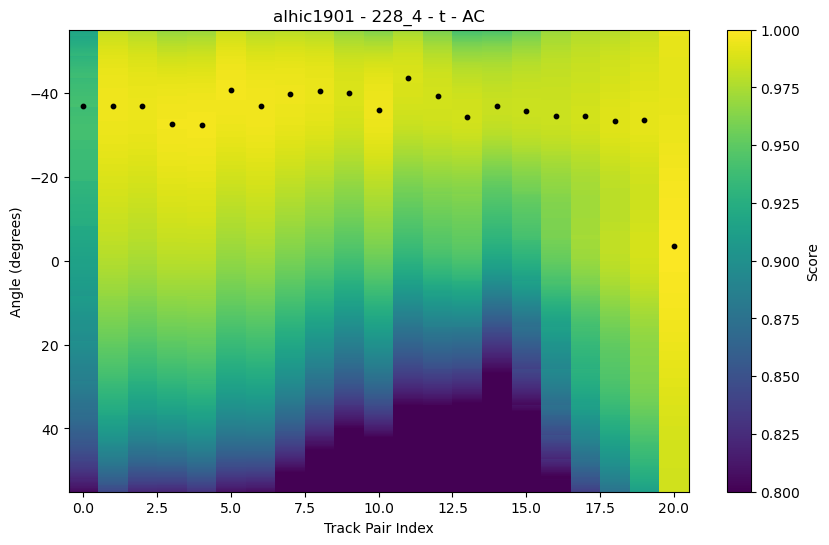

<Figure size 640x480 with 0 Axes>

In [96]:
# loop through rows of face_df
for idx, row in face_df.iterrows():

    all_scores = row['all_scores']

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(range(all_scores.shape[1]), test_angle, all_scores, cmap='viridis', shading='auto', norm=plt.Normalize(vmin=0.8, vmax=1))
    plt.colorbar(label='Score')
    plt.title(row['core']+' - '+row['section']+' - '+row['face']+' - '+row['ACorDC'])
    plt.xlabel('Track Pair Index')
    plt.ylabel('Angle (degrees)')
    plt.gca().invert_yaxis()  # Invert y-axis to match the order of test_angle

    # Add black dots at the maximum point in each column
    max_indices = np.argmax(all_scores, axis=0)
    plt.scatter(range(all_scores.shape[1]), test_angle[max_indices], color='black', s=10, label='Max Points')

    if row['ACorDC'] == 'AC' and row['face'] == 't':
        plt.show()
    else:
        plt.close()

    # Save the figure
    plt.savefig(path_to_figures + 'face_diagnostic/'+ row['core']+'-'+row['section']+'-'+row['face']+'-'+row['ACorDC']+'_angle.png', dpi=300)

## Compute True Angles

In [ ]:
# Make new dataframe to store final angles

In [ ]:
all_scores